Building a Customer Churn Classifier using the Telco dataset. It includes:

• Data cleaning

• Handling imbalanced classes

• XGBoost model training

• Evaluation using AUC and F1-score

• A target AUC of > 0.85

In [1]:
!pip install xgboost optuna imbalanced-learn --quiet


In [2]:
!pip uninstall -y xgboost
!pip install xgboost==1.7.6 --quiet


Found existing installation: xgboost 1.7.6
Uninstalling xgboost-1.7.6:
  Successfully uninstalled xgboost-1.7.6


In [3]:
# Step 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, RocCurveDisplay

In [5]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [6]:
# Step 3: Load the dataset (updated working URL)
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)


In [7]:
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Drop customerID as it's not useful
df.drop('customerID', axis=1, inplace=True)

In [9]:
# Replace spaces with NaN and convert to float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
# Fill missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-457876299.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [11]:

# Encode target column
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
# Binary encoding for Yes/No columns
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

In [13]:
# Encode gender manually
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [14]:
# Convert categorical columns using one-hot encoding
cat_cols = df.select_dtypes(include='object').columns.tolist()
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [15]:
X = df.drop('Churn', axis=1)
y = df['Churn']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [19]:
import optuna

In [25]:
def objective(trial):
    # Define hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 5),
        "eval_metric": "auc",
        "use_label_encoder": False,
        "random_state": 42,
    }

    # Import EarlyStopping inside the function
    from xgboost.callback import EarlyStopping

    # Create and train the model using unpacked params
    model = XGBClassifier(**params)
    model.fit(
        X_train_scaled, y_train_sm,
        eval_set=[(X_test_scaled, y_test)],
        callbacks=[EarlyStopping(rounds=20)],
        verbose=False
    )

    # Evaluate AUC
    preds = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, preds)
    return auc


In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)



[I 2025-08-07 17:54:23,538] A new study created in memory with name: no-name-f3f16246-b2b6-49ba-804a-cb71aa15d581
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-08-07 17:54:24,914] Trial 0 finished with value: 0.8314565088222378 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.03353830690679165, 'subsample': 0.6315422809212001, 'colsample_bytree': 0.9660889600503428, 'gamma': 2.284766667345699, 'reg_lambda': 9.589946983964081, 'scale_pos_weight': 3.230491709074649}. Best is trial 0 with value: 0.8314565088222378.
/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning

In [27]:
print("🎯 Best AUC:", study.best_value)
print("📦 Best Parameters:", study.best_params)

🎯 Best AUC: 0.835216616290785
📦 Best Parameters: {'n_estimators': 297, 'max_depth': 4, 'learning_rate': 0.04142233454609756, 'subsample': 0.8569322164844076, 'colsample_bytree': 0.6618044063620481, 'gamma': 2.102057003583528, 'reg_lambda': 6.3332287740502355, 'scale_pos_weight': 4.028709387898354}


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



🔍 Final Evaluation Metrics:
✅ F1 Score: 0.6051
✅ AUC Score: 0.8295

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1035
           1       0.46      0.89      0.61       374

    accuracy                           0.69      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.69      0.71      1409



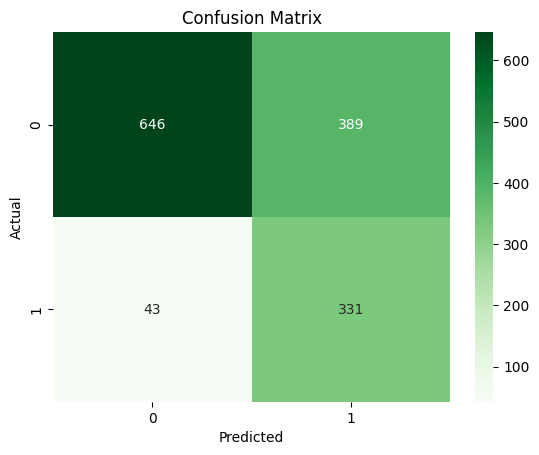

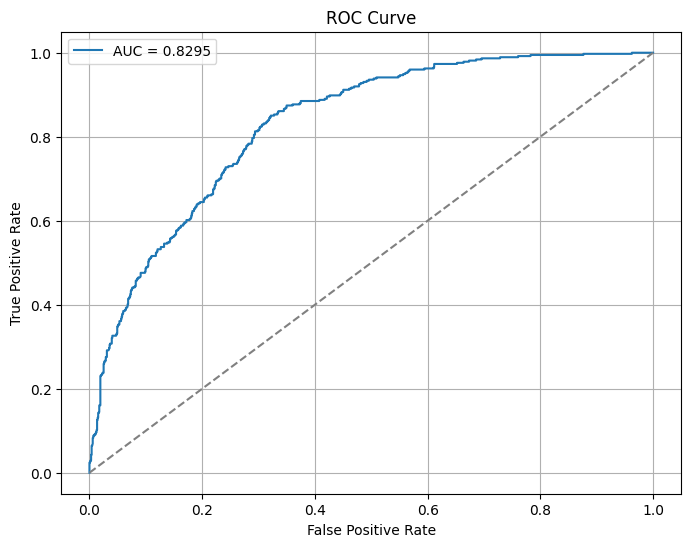

In [30]:
# Final model training
best_params = study.best_params
best_params.update({
    "eval_metric": "auc",
    "use_label_encoder": False,
    "random_state": 42,
})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_scaled, y_train_sm)

# Final predictions
y_pred = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n🔍 Final Evaluation Metrics:")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ AUC Score: {auc:.4f}")

# Classification report (optional but useful)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (manual version — avoids compatibility errors)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
